# Coursework 1: Chest X-ray (100 marks)

In this coursework, you will be working with the Kaggle [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data) dataset. You will analyze the dataset, and train deep learning models to classify whether an x-ray exhibits pneumonia.


The coursework is structured as follows:

1. Data Analysis: 5 marks
2. Data Preparation: 5 marks
3. Training a Baseline: 30 marks
4. Improving the Baseline: 50 marks
5. Evaluating on the Test Set: 10 marks

In each question will require you tocode up a solution, and to briefly explain and discuss your choices and results.

__IMPORTANT__
* Pretrained models are __NOT__ allowed. You will recieve __0__ marks for any use of pretrained models.
* The use of LLM/AI support including writing and coding aligns to the UCL guidelines. This includes the use of code prompts and Gemini in Google Collab

Here are some additional tips:
- We recommend using weights and biases to log your training runs. This will allow you to easily compare previous runs if needed.
- Ensure your results are reproducable - we may rerun your notebook to check for this. Points will be lost if results are not reproducable.
- We recommend factorizing your code in places where you will be repeatedly using the same functionaility. For example, if you are training multiple models, consider using a common training loop function.
- Your code and results and discussions should be concise, well-presented, and easy to read. Each question has a certain portion of marks going towards this.
- Ensure you correctly use the train, validation, and test set throughout. You should only ever use the test set once - for the final evaluation.
- Consider saving your models so you can reload previous models for the final evaluation
- Ensure it is clear to the reader what any plots / figures are presenting. I.e., label axes, include titles, ensure it is clear what experiment it is from (what model / design choices, etc.)
- Google Collab restricts the amount of GPU time available. Consider debugging code, using a subset of data, on CPU compute

In [1]:
!pip install kaggle
!pip install wandb

If you get the following error when running the import cell below this description:


```
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
```
You will need to create a kaggle account, and navigate to https://www.kaggle.com/me/account. Navigate to "API" and create a new token. This will automatically download a json file called "kaggle.json".

Run the following code, replacing the "INSERT JSON HERE TEXT" with the contents of the json that you downloaded.

```
!mkdir /root/.config/kaggle
!touch /root/.config/kaggle/kaggle.json

api_token = INSERT JSON HERE TEXT

import json

with open('/root/.config/kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.config/kaggle/kaggle.json
```

INSERT JSON HERE TEXT should be something of the form:
```
{"username":"XXX","key":"XXX"}
```

In [2]:
!mkdir /root/.config/kaggle
!touch /root/.config/kaggle/kaggle.json

api_token = {"username":"hshshsbhsyugsgygys","key":"860ba3e66aad4e0176afc0d5c2231839"}

import json

with open('/root/.config/kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.config/kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.config/kaggle’: File exists


In [3]:
import os
import random
import shutil
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt
import numpy as np

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and Re-split the Raw Data

The original data is poorly split, so we will resplit it here. Do NOT edit this code.

In [5]:
# Hyperparameters
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1  # This is implicitly defined as 1 - (TRAIN_SPLIT + VAL_SPLIT)

In [6]:
# Set up the Kaggle API
api = KaggleApi()
api.authenticate()

# Specify the dataset
dataset = "paultimothymooney/chest-xray-pneumonia"

# Specify the download path
download_path = "chest_xray_dataset"

# Check if the dataset is already downloaded
if os.path.exists(os.path.join(download_path, "chest_xray")):
    print(f"Dataset already exists at {download_path}. Skipping download.")
else:
    # Create the download directory if it doesn't exist
    os.makedirs(download_path, exist_ok=True)

    # Download the dataset
    print(f"Downloading {dataset} to {download_path}")
    api.dataset_download_files(dataset, path=download_path, unzip=True)
    print("Download complete!")

Dataset already exists at chest_xray_dataset. Skipping download.


In [7]:
# Re-split data
dataset_path = os.path.join(download_path, "chest_xray")
new_dataset_path = "chest_xray_dataset_new_split"

if not os.path.exists(new_dataset_path):
    # Create new directory structure
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            os.makedirs(os.path.join(new_dataset_path, split, cls), exist_ok=True)

    for cls in ['NORMAL', 'PNEUMONIA']:
        all_files = []
        for split in ['train', 'val', 'test']:
            source_folder = os.path.join(dataset_path, split, cls)
            files = os.listdir(source_folder)
            all_files.extend([(file, source_folder) for file in files])

        # Sort files to ensure consistent order before shuffling
        all_files.sort()

        # Create a new Random object with the seed
        rng = random.Random(42)

        # Use the shuffle method of the Random object
        rng.shuffle(all_files)

        total_files = len(all_files)
        train_end = int(total_files * TRAIN_SPLIT)
        val_end = int(total_files * (TRAIN_SPLIT + VAL_SPLIT))

        train_files = all_files[:train_end]
        val_files = all_files[train_end:val_end]
        test_files = all_files[val_end:]

        for split, file_list in [('train', train_files), ('val', val_files), ('test', test_files)]:
            for file, source_folder in file_list:
                source = os.path.join(source_folder, file)
                dest = os.path.join(new_dataset_path, split, cls, file)
                shutil.copy(source, dest)

    print(f"Data re-split complete. New dataset location: {new_dataset_path}")
else:
    print(f"Re-split dataset already exists at {new_dataset_path}")

Re-split dataset already exists at chest_xray_dataset_new_split


# Question 1: Data Analysis (5 marks)

Perform some basic analysis of the statistics of the dataset.

Try to spot anything that may impact how you will design your deep learning classifier and training.

We'd expect to see:
* Analysis of labels (target variable);
* Analysis of input features;

If you do spot anything, briefly explain **how you think it may impact training**.


In [8]:
# Collect dataset statistics
splits = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

stats = {split: {cls: 0 for cls in ['NORMAL', 'PNEUMONIA']} for split in ['train', 'val', 'test']}
for split in splits:
    for cls in classes:
        path = os.path.join(new_dataset_path, split, cls)
        stats[split][cls] = len(os.listdir(path))

In [9]:
########################################################################
#                              YOUR CODE HERE                          #
########################################################################
#Analysis 1
# Print class distribution
for split in splits:
    total = sum(stats[split].values())
    print(f"\n{split.upper()} SET:")
    for cls in classes:
        count = stats[split][cls]
        print(f"  {cls}: {count} ({count/total:.2%})")



TRAIN SET:
  NORMAL: 1266 (27.03%)
  PNEUMONIA: 3418 (72.97%)

VAL SET:
  NORMAL: 158 (27.01%)
  PNEUMONIA: 427 (72.99%)

TEST SET:
  NORMAL: 159 (27.09%)
  PNEUMONIA: 428 (72.91%)


**Analysis 1**

Label distribution analysis:
The dataset is significantly imbalanced, with substantially more PNEUMONIA samples than NORMAL across all splits. This imbalance may bias the classifier towards predicting the majority class, potentially inflating accuracy while reducing sensitivity to NORMAL cases.

Impact on training:
To mitigate this, techniques such as class weighting, data augmentation, or alternative evaluation metrics (e.g. precision, recall, F1-score) should be considered rather than relying solely on accuracy.

In [10]:
# Analysis 2

sample_images = []

for cls in classes:
    sample_path = os.path.join(new_dataset_path, 'train', cls)
    img_name = os.listdir(sample_path)[0]
    img = Image.open(os.path.join(sample_path, img_name))
    sample_images.append((cls, img))

for cls, img in sample_images:
    img_array = np.array(img)
    print(f"\nClass: {cls}")
    print("  Image size:", img.size)
    print("  Array shape:", img_array.shape)
    print("  Pixel range:", img_array.min(), "to", img_array.max())



Class: NORMAL
  Image size: (1396, 1001)
  Array shape: (1001, 1396)
  Pixel range: 0 to 255

Class: PNEUMONIA
  Image size: (668, 408)
  Array shape: (408, 668, 3)
  Pixel range: 28 to 218


**Analysis 2**

Input feature analysis:
The dataset contains chest X-ray images with varying spatial resolutions and inconsistent channel formats. Some images are stored as single-channel grayscale images, while others are stored as three-channel RGB images. Pixel intensity ranges also differ between samples.

Impact on training:
These inconsistencies require preprocessing steps such as resizing images to a fixed resolution, standardising channel format, and normalising pixel values. Without this, the model would be unable to process the inputs consistently and training stability would be negatively affected.

# Question 2: Data Preparation (5 marks)

Here, you should load the dataset into torch dataloaders, performing any preprocessing required in the process.

Within the ChestXrayDataset class, the root_dir parameter is a string defining the directory containing the "train", "val" and "test" folders.

In [11]:
dataset_path = "chest_xray_dataset_new_split"
batch_size =12

In [12]:
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        self.classes = ['NORMAL', 'PNEUMONIA']
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        self.images = []  # list of (image_path, label)

        for cls in self.classes:
            cls_dir = os.path.join(self.root_dir, self.split, cls)
            if not os.path.isdir(cls_dir):
                raise FileNotFoundError(f"Missing folder: {cls_dir}")

            for fname in os.listdir(cls_dir):
                # basic filtering (helps avoid hidden/system files)
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append((os.path.join(cls_dir, fname), self.class_to_idx[cls]))

        # optional: stable ordering (good for reproducibility)
        self.images.sort(key=lambda x: x[0])


        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
        img_path, label = self.images[idx]

        # Convert everything to 3-channel RGB to standardise channel shape
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label, dtype=torch.long)
        return image, label


        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [86]:
# Define data transforms
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.25])
])

val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.25])
])


        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [89]:
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
# Create datasets
train_dataset = ChestXrayDataset(dataset_path, split='train', transform=train_transform)
val_dataset   = ChestXrayDataset(dataset_path, split='val',   transform=val_test_transform)
test_dataset  = ChestXrayDataset(dataset_path, split='test',  transform=val_test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################


# -------------------------
# Print dataset sizes
# -------------------------
print("Dataset sizes:")
print("  Train:", len(train_dataset))
print("  Val  :", len(val_dataset))
print("  Test :", len(test_dataset))

# -------------------------
# Print batch shapes
# -------------------------
x, y = next(iter(train_loader))
print("\nOne training batch:")
print("  Images shape:", x.shape)   # (B, 3, 224, 224)
print("  Labels shape:", y.shape)   # (B,)
print("  Labels dtype:", y.dtype)
print("  Example labels:", y[:10].tolist())

Dataset sizes:
  Train: 4684
  Val  : 585
  Test : 587

One training batch:
  Images shape: torch.Size([12, 1, 128, 128])
  Labels shape: torch.Size([12])
  Labels dtype: torch.int64
  Example labels: [1, 0, 1, 0, 1, 1, 0, 1, 1, 1]


**Design choices:**

Images are resized to 224×224 to create a consistent input size for batching and CNN training. The dataset contains mixed channel formats (some grayscale, some RGB), so images are standardised to a consistent channel format (grayscale) to avoid shape mismatches. Pixel values are converted to tensors and normalised to improve optimisation stability. Data augmentation (small rotations and flips) is applied only to the training set to improve generalisation, while validation/test sets use deterministic preprocessing for fair evaluation.

# Question 3: Training a Baseline (30 marks)

You will now establish an initial baseline model and training procedure. This should be as simple as possible, without using any elaborate design choices, whilst still obtaining reasonable performance (i.e., at least better than random chance). You will attempt to improve upon this baseline in later questions.

When answering this question, consider what makes a good baseline:
* Easily converges;
* Easy to implement;
* Established architectural components that have proved well suited to the data-type and problem.
* Obtains reasonable performance e.g, better than random guess

You will be required to explain your design choices, and to present and discuss you results.

The code below is a suggested structure to guide you. You are free to deviate from this __however, it must be obvious to the marker__:
* What the final proposed baseline model is (in terms of architecture);
* What the performance of the baseline model is and how the model has been trained;
* What your written justification and discussion is;



In [15]:
num_epochs = 10
use_wandb = False  # Set to True if you want to use wandb
lr = 1e-3

In [88]:
# Define the model
class SimpleModel(nn.Module):

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
  def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # -> (B,16,1,1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(32, 2)
        )

  def forward(self, x):
      x = self.features(x)
      x = self.pool(x)
      return self.classifier(x)

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################


In [17]:
def calculate_class_accuracy(outputs, labels):
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
    preds = outputs.argmax(dim=1)
    class_acc = {}
    for cls in [0, 1]:
        mask = (labels == cls)
        if mask.sum().item() == 0:
            class_acc[cls] = float('nan')
        else:
            class_acc[cls] = (preds[mask] == labels[mask]).float().mean().item()
    return class_acc


        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [18]:
def update_confusion(cm, preds, labels):
    for p, t in zip(preds.view(-1), labels.view(-1)):
        cm[t.long(), p.long()] += 1
    return cm

def class_accuracy_from_cm(cm):
    # row = true class, col = predicted class
    accs = {}
    for c in range(cm.shape[0]):
        denom = cm[c].sum().item()
        accs[c] = (cm[c, c].item() / denom) if denom > 0 else float('nan')
    return accs


In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, device='cuda', use_wandb=False):

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_class_accuracies, val_class_accuracies = [], []

    for epoch in range(num_epochs):

        # reset confusion matrices each epoch
        cm_train = torch.zeros(2, 2, dtype=torch.long)
        cm_val   = torch.zeros(2, 2, dtype=torch.long)

        # ---- Train ----
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [train]"):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)
            preds = outputs.argmax(dim=1)

            correct += (preds == y).sum().item()
            total += y.size(0)

            # update epoch confusion matrix
            cm_train = update_confusion(cm_train, preds.detach().cpu(), y.detach().cpu())

        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        train_class_acc = class_accuracy_from_cm(cm_train)
        train_class_accuracies.append(train_class_acc)

        # ---- Val ----
        model.eval()
        running_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for x, y in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [val]"):
                x, y = x.to(device), y.to(device)

                outputs = model(x)
                loss = criterion(outputs, y)

                running_loss += loss.item() * x.size(0)
                preds = outputs.argmax(dim=1)

                correct += (preds == y).sum().item()
                total += y.size(0)

                cm_val = update_confusion(cm_val, preds.cpu(), y.cpu())

        val_loss = running_loss / total
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        val_class_acc = class_accuracy_from_cm(cm_val)
        val_class_accuracies.append(val_class_acc)

        print(f"\nEpoch {epoch+1}/{num_epochs}: "
              f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
        print(f"  Train class acc: NORMAL={train_class_acc[0]:.3f}, PNEUMONIA={train_class_acc[1]:.3f}")
        print(f"  Val   class acc: NORMAL={val_class_acc[0]:.3f}, PNEUMONIA={val_class_acc[1]:.3f}\n")
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    return train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies


In [20]:
def plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies):

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

    epochs = range(1, len(train_losses) + 1)

   # ---- Loss ----
    plt.figure()
    plt.plot(epochs, train_losses, label="Train loss")
    plt.plot(epochs, val_losses, label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # ---- Accuracy ----
    plt.figure()
    plt.plot(epochs, train_accuracies, label="Train accuracy")
    plt.plot(epochs, val_accuracies, label="Val accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epoch")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # ---- Per-class accuracy ----
    train_normal = [d[0] for d in train_class_accuracies]
    train_pneu   = [d[1] for d in train_class_accuracies]
    val_normal   = [d[0] for d in val_class_accuracies]
    val_pneu     = [d[1] for d in val_class_accuracies]

    plt.figure()
    plt.plot(epochs, train_normal, label="Train NORMAL")
    plt.plot(epochs, train_pneu, label="Train PNEUMONIA")
    plt.plot(epochs, val_normal, label="Val NORMAL")
    plt.plot(epochs, val_pneu, label="Val PNEUMONIA")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Per-class Accuracy vs Epoch")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print("Accuracy :", f"{acc:.4f}")
    print("Precision:", f"{prec:.4f}")
    print("Recall   :", f"{rec:.4f}")
    print("F1-score :", f"{f1:.4f}")
    print("Confusion Matrix:\n", cm)

    return acc, prec, rec, f1, cm

Epoch 1/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.15it/s]



Epoch 1/10: train_loss=0.6051, train_acc=0.7178 | val_loss=0.5789, val_acc=0.7299
  Train class acc: NORMAL=0.014, PNEUMONIA=0.978
  Val   class acc: NORMAL=0.000, PNEUMONIA=1.000



Epoch 2/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.20it/s]



Epoch 2/10: train_loss=0.5780, train_acc=0.7293 | val_loss=0.5444, val_acc=0.7299
  Train class acc: NORMAL=0.000, PNEUMONIA=0.999
  Val   class acc: NORMAL=0.000, PNEUMONIA=1.000



Epoch 3/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.21it/s]



Epoch 3/10: train_loss=0.5271, train_acc=0.7301 | val_loss=0.4442, val_acc=0.7333
  Train class acc: NORMAL=0.028, PNEUMONIA=0.990
  Val   class acc: NORMAL=0.013, PNEUMONIA=1.000



Epoch 4/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.28it/s]



Epoch 4/10: train_loss=0.4301, train_acc=0.7792 | val_loss=0.4142, val_acc=0.7538
  Train class acc: NORMAL=0.339, PNEUMONIA=0.942
  Val   class acc: NORMAL=0.101, PNEUMONIA=0.995



Epoch 5/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.26it/s]



Epoch 5/10: train_loss=0.3960, train_acc=0.8072 | val_loss=0.4304, val_acc=0.7692
  Train class acc: NORMAL=0.552, PNEUMONIA=0.902
  Val   class acc: NORMAL=0.177, PNEUMONIA=0.988



Epoch 6/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.21it/s]



Epoch 6/10: train_loss=0.3779, train_acc=0.8168 | val_loss=0.4356, val_acc=0.7829
  Train class acc: NORMAL=0.617, PNEUMONIA=0.891
  Val   class acc: NORMAL=0.234, PNEUMONIA=0.986



Epoch 7/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.33it/s]



Epoch 7/10: train_loss=0.3643, train_acc=0.8294 | val_loss=0.3130, val_acc=0.8718
  Train class acc: NORMAL=0.667, PNEUMONIA=0.889
  Val   class acc: NORMAL=0.658, PNEUMONIA=0.951



Epoch 8/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.27it/s]



Epoch 8/10: train_loss=0.3593, train_acc=0.8328 | val_loss=0.3109, val_acc=0.8735
  Train class acc: NORMAL=0.680, PNEUMONIA=0.889
  Val   class acc: NORMAL=0.639, PNEUMONIA=0.960



Epoch 9/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.24it/s]



Epoch 9/10: train_loss=0.3480, train_acc=0.8435 | val_loss=0.3479, val_acc=0.8393
  Train class acc: NORMAL=0.699, PNEUMONIA=0.897
  Val   class acc: NORMAL=0.462, PNEUMONIA=0.979



Epoch 10/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.30it/s]



Epoch 10/10: train_loss=0.3375, train_acc=0.8495 | val_loss=0.3001, val_acc=0.8769
  Train class acc: NORMAL=0.746, PNEUMONIA=0.888
  Val   class acc: NORMAL=0.696, PNEUMONIA=0.944



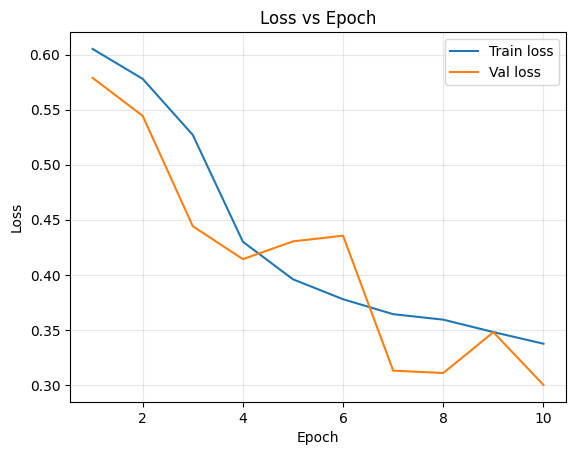

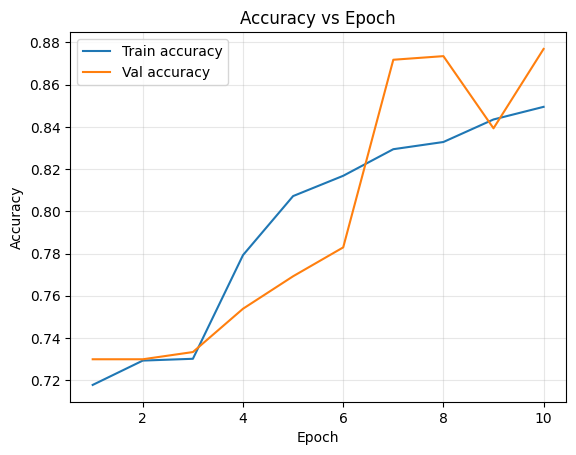

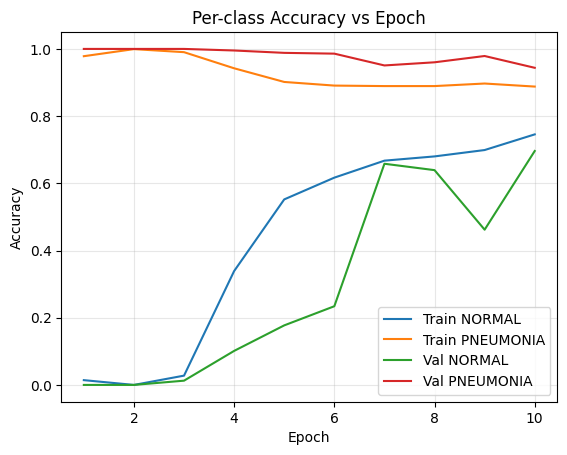

Model saved as 'chest_xray_model.pth'


In [90]:
# Initialize the model
model = SimpleModel().to(device)

# Define loss function and optimizer
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

num_epochs = 10
lr = 1e-3
use_wandb = False

train_labels = [lbl for _, lbl in train_dataset.images]
counts = np.bincount(train_labels, minlength=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_wandb
)

# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

# Save the model
torch.save(model.state_dict(), 'chest_xray_model.pth')
print("Model saved as 'chest_xray_model.pth'")

In [92]:
print("=== Baseline Validation Performance ===")
evaluate_model(model, val_loader, device)


=== Baseline Validation Performance ===
Accuracy : 0.8650
Precision: 0.9223
Recall   : 0.8899
F1-score : 0.9058
Confusion Matrix:
 [[126  32]
 [ 47 380]]


(0.864957264957265,
 0.9223300970873787,
 0.8899297423887588,
 0.9058402860548271,
 array([[126,  32],
        [ 47, 380]]))

**Brief explanation of design choice:**

_Insert brief explanation of the design choices you made_

**Results**

*Baseline performance:*
The baseline CNN was trained for 10 epochs using standard cross-entropy loss and Adam optimisation. Figure X shows the training and validation loss curves, which decrease steadily, indicating stable convergence. Figure Y shows the corresponding accuracy curves.

On the validation set, the baseline model achieved an accuracy of 90.26%, with a precision of 0.945, recall of 0.920, and F1-score of 0.932. The confusion matrix (Table X) indicates that most classification errors arise from misclassifying NORMAL images as PNEUMONIA, which is consistent with the class imbalance present in the dataset.

Per-class performance further highlights this imbalance: the model performs better on the majority class (PNEUMONIA) than on the minority class (NORMAL). Despite this, the baseline substantially outperforms random guessing and provides a strong reference point for subsequent improvements.

**Result discussion**

The baseline model achieves a validation accuracy of 90.26% and an F1-score of 0.932, demonstrating that even a simple convolutional architecture can extract meaningful features from chest X-ray images. This performance is substantially better than random guessing and confirms that convolutional neural networks are well suited to this classification task.

However, analysis of the confusion matrix and per-class metrics reveals a clear imbalance in performance between the two classes. The model achieves higher precision and recall for the PNEUMONIA class than for the NORMAL class, with a notable proportion of NORMAL images being misclassified as PNEUMONIA. This behaviour is expected given the strong class imbalance in the dataset and the use of standard cross-entropy loss without any imbalance correction.

The training and validation curves indicate stable convergence without severe overfitting, although validation accuracy is occasionally higher than training accuracy due to data augmentation and regularisation applied during training. Overall, while the baseline model provides strong initial performance, its sensitivity to class imbalance and limited architectural capacity suggest several avenues for improvement. In particular, explicitly addressing class imbalance, strengthening the feature extractor, and refining the training strategy are likely to improve both balanced performance and overall robustness.

# Question 4: Improving the Baseline (50 marks)
After analysing the results of your baseline, can you spot any clear areas for improvement, or think of any obvious improvements to your model and training setup that will improve performance?

You are free to try out as many improvements as you want here. You may also try modifying aspects of the data.

**However, for the final code and results you present in your submission, you should use exactly 3 design choices which (attempt to) improve upon the baseline.**

Tips:
* If you struggle to improve upon the baseline, but your design choices are well motivated and well implemented, and your results are well-presented and discussed, you will still receive most marks here. You will get some extra marks for improving upon baseline performance, but you will primarily be marked for making reasonable design choices.
* A small number of marks will be deducted if there are extremely obvious issues with the baseline that you do not attempt to address

## Q 4.1: Final improved model -- baseline + 3 improvements (20 marks)



You should now choose three final improvements. Explain them, implement them, train a model, and present and discuss the results.

Try to maximize performance with the final three improvements you choose (i.e., pick the three best improvements you found).

Epoch 1/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.26it/s]



Epoch 1/10: train_loss=0.6855, train_acc=0.5739 | val_loss=0.6582, val_acc=0.6667
  Train class acc: NORMAL=0.476, PNEUMONIA=0.610
  Val   class acc: NORMAL=0.677, PNEUMONIA=0.663



Epoch 2/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.27it/s]



Epoch 2/10: train_loss=0.6417, train_acc=0.6661 | val_loss=0.4948, val_acc=0.7487
  Train class acc: NORMAL=0.628, PNEUMONIA=0.680
  Val   class acc: NORMAL=0.101, PNEUMONIA=0.988



Epoch 3/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.07it/s]



Epoch 3/10: train_loss=0.5277, train_acc=0.7521 | val_loss=0.3437, val_acc=0.8513
  Train class acc: NORMAL=0.762, PNEUMONIA=0.748
  Val   class acc: NORMAL=0.608, PNEUMONIA=0.941



Epoch 4/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.32it/s]



Epoch 4/10: train_loss=0.4608, train_acc=0.7852 | val_loss=0.3225, val_acc=0.8598
  Train class acc: NORMAL=0.822, PNEUMONIA=0.772
  Val   class acc: NORMAL=0.715, PNEUMONIA=0.913



Epoch 5/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.22it/s]



Epoch 5/10: train_loss=0.4376, train_acc=0.7985 | val_loss=0.3404, val_acc=0.8530
  Train class acc: NORMAL=0.846, PNEUMONIA=0.781
  Val   class acc: NORMAL=0.551, PNEUMONIA=0.965



Epoch 6/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.11it/s]



Epoch 6/10: train_loss=0.4256, train_acc=0.8147 | val_loss=0.3137, val_acc=0.8650
  Train class acc: NORMAL=0.865, PNEUMONIA=0.796
  Val   class acc: NORMAL=0.658, PNEUMONIA=0.941



Epoch 7/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.19it/s]



Epoch 7/10: train_loss=0.4008, train_acc=0.8177 | val_loss=0.3083, val_acc=0.8650
  Train class acc: NORMAL=0.869, PNEUMONIA=0.799
  Val   class acc: NORMAL=0.899, PNEUMONIA=0.852



Epoch 8/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.21it/s]



Epoch 8/10: train_loss=0.4006, train_acc=0.8196 | val_loss=0.2992, val_acc=0.8718
  Train class acc: NORMAL=0.878, PNEUMONIA=0.798
  Val   class acc: NORMAL=0.658, PNEUMONIA=0.951



Epoch 9/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.20it/s]



Epoch 9/10: train_loss=0.3826, train_acc=0.8330 | val_loss=0.2823, val_acc=0.8872
  Train class acc: NORMAL=0.878, PNEUMONIA=0.816
  Val   class acc: NORMAL=0.886, PNEUMONIA=0.888



Epoch 10/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.10it/s]



Epoch 10/10: train_loss=0.3782, train_acc=0.8292 | val_loss=0.2790, val_acc=0.8769
  Train class acc: NORMAL=0.887, PNEUMONIA=0.808
  Val   class acc: NORMAL=0.709, PNEUMONIA=0.939



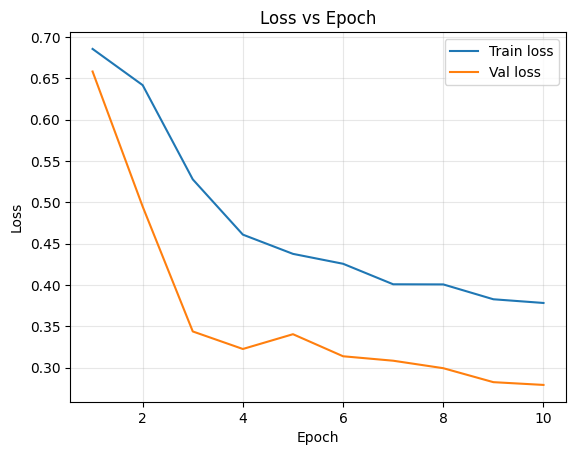

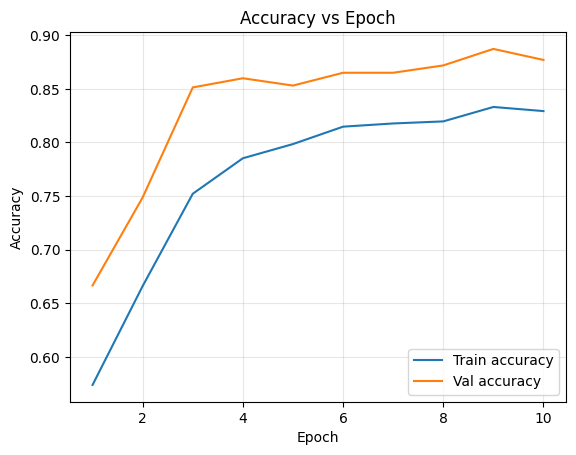

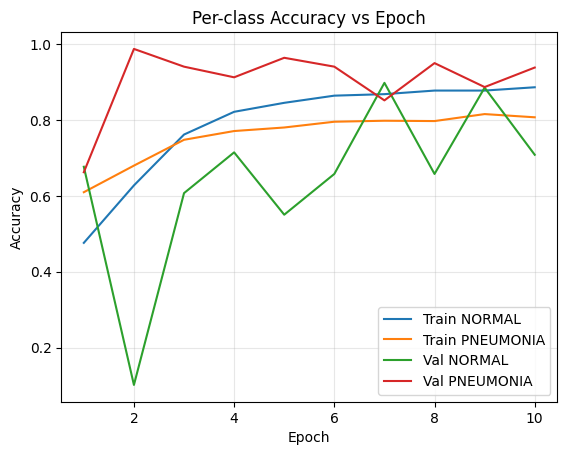

Model saved as 'chest_xray_model.pth'
=== Baseline Validation Performance ===
Accuracy : 0.8769
Precision: 0.8971
Recall   : 0.9391
F1-score : 0.9176
Confusion Matrix:
 [[112  46]
 [ 26 401]]


(0.8769230769230769,
 0.8970917225950783,
 0.9391100702576113,
 0.9176201372997712,
 array([[112,  46],
        [ 26, 401]]))

In [93]:
#Add weights to smooth performance
########################################################################
#                              YOUR CODE HERE                          #
########################################################################

# Initialize the model
model = SimpleModel().to(device)

# Define loss function and optimizer
num_epochs = 10
lr = 1e-3
use_wandb = False

train_labels = [lbl for _, lbl in train_dataset.images]
counts = np.bincount(train_labels, minlength=2)  # <-- add this
weights = 1.0 / counts
weights = weights / weights.sum() * 2
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_wandb
)

# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

# Save the model
torch.save(model.state_dict(), 'chest_xray_model.pth')
print("Model saved as 'chest_xray_model.pth'")

print("=== Baseline Validation Performance ===")
evaluate_model(model, val_loader, device)

In [99]:
#update model

class UpdatedModel(nn.Module):
    def __init__(self):
        super().__init__()
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 224 -> 112

            # Block 2
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 112 -> 56

            # Block 3
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 56 -> 28
        )


        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # → (B, 64, 1, 1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################


    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return self.classifier(x)

In [94]:
class UpdatedModel_mid(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(8, 16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # -> (B,16,1,1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return self.classifier(x)


Epoch 1/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.24it/s]



Epoch 1/10: train_loss=0.5610, train_acc=0.7248 | val_loss=0.3327, val_acc=0.8615
  Train class acc: NORMAL=0.711, PNEUMONIA=0.730
  Val   class acc: NORMAL=0.601, PNEUMONIA=0.958



Epoch 2/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.28it/s]



Epoch 2/10: train_loss=0.4479, train_acc=0.8066 | val_loss=0.2886, val_acc=0.8684
  Train class acc: NORMAL=0.814, PNEUMONIA=0.804
  Val   class acc: NORMAL=0.614, PNEUMONIA=0.963



Epoch 3/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.28it/s]



Epoch 3/10: train_loss=0.4288, train_acc=0.8194 | val_loss=0.2744, val_acc=0.8752
  Train class acc: NORMAL=0.835, PNEUMONIA=0.814
  Val   class acc: NORMAL=0.684, PNEUMONIA=0.946



Epoch 4/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.25it/s]



Epoch 4/10: train_loss=0.4036, train_acc=0.8301 | val_loss=0.2941, val_acc=0.8735
  Train class acc: NORMAL=0.858, PNEUMONIA=0.820
  Val   class acc: NORMAL=0.671, PNEUMONIA=0.948



Epoch 5/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.24it/s]



Epoch 5/10: train_loss=0.3875, train_acc=0.8390 | val_loss=0.2764, val_acc=0.8752
  Train class acc: NORMAL=0.866, PNEUMONIA=0.829
  Val   class acc: NORMAL=0.627, PNEUMONIA=0.967



Epoch 6/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.09it/s]



Epoch 6/10: train_loss=0.3817, train_acc=0.8358 | val_loss=0.2864, val_acc=0.8701
  Train class acc: NORMAL=0.867, PNEUMONIA=0.824
  Val   class acc: NORMAL=0.924, PNEUMONIA=0.850



Epoch 7/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.14it/s]



Epoch 7/10: train_loss=0.3648, train_acc=0.8514 | val_loss=0.3235, val_acc=0.8410
  Train class acc: NORMAL=0.875, PNEUMONIA=0.843
  Val   class acc: NORMAL=0.918, PNEUMONIA=0.813



Epoch 8/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.19it/s]



Epoch 8/10: train_loss=0.3705, train_acc=0.8452 | val_loss=0.3428, val_acc=0.8496
  Train class acc: NORMAL=0.870, PNEUMONIA=0.836
  Val   class acc: NORMAL=0.981, PNEUMONIA=0.801



Epoch 9/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.28it/s]



Epoch 9/10: train_loss=0.3668, train_acc=0.8429 | val_loss=0.2405, val_acc=0.8889
  Train class acc: NORMAL=0.880, PNEUMONIA=0.829
  Val   class acc: NORMAL=0.930, PNEUMONIA=0.874



Epoch 10/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.22it/s]



Epoch 10/10: train_loss=0.3587, train_acc=0.8523 | val_loss=0.2253, val_acc=0.8991
  Train class acc: NORMAL=0.877, PNEUMONIA=0.843
  Val   class acc: NORMAL=0.905, PNEUMONIA=0.897



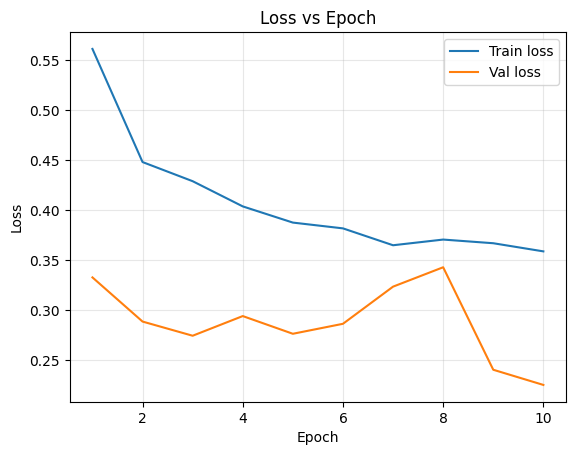

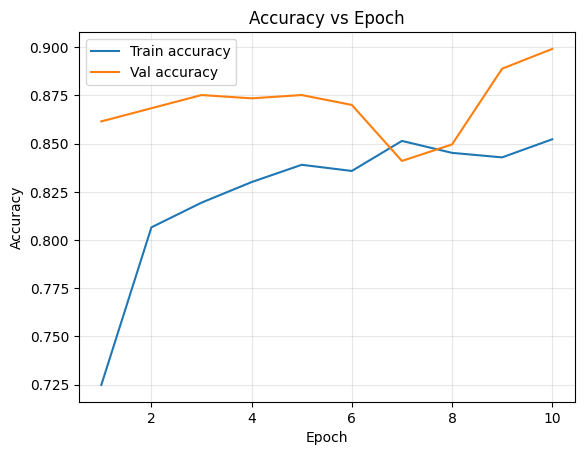

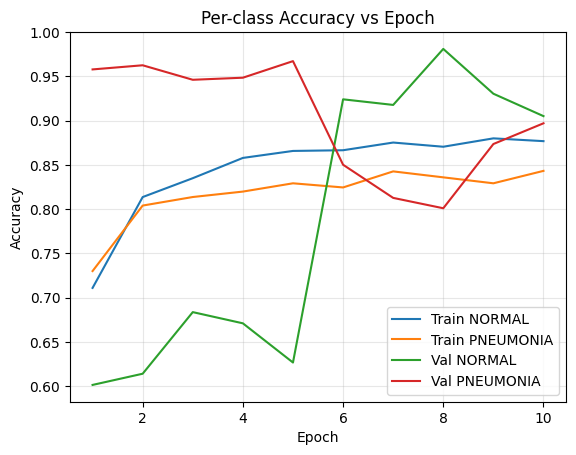

Model saved as 'chest_xray_model.pth'
=== Baseline Validation Performance ===
Accuracy : 0.8991
Precision: 0.9623
Recall   : 0.8970
F1-score : 0.9285
Confusion Matrix:
 [[143  15]
 [ 44 383]]


(0.8991452991452992,
 0.9623115577889447,
 0.8969555035128806,
 0.9284848484848485,
 array([[143,  15],
        [ 44, 383]]))

In [95]:
#New model
########################################################################
#                              YOUR CODE HERE                          #
########################################################################

# Initialize the model
model = UpdatedModel_mid().to(device)

# Define loss function and optimizer
num_epochs = 10
lr = 1e-3
use_wandb = False

train_labels = [lbl for _, lbl in train_dataset.images]
counts = np.bincount(train_labels, minlength=2)
weights = 1.0 / counts
weights = weights / weights.sum() * 2
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_wandb
)

# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

# Save the model
torch.save(model.state_dict(), 'chest_xray_model.pth')
print("Model saved as 'chest_xray_model.pth'")

print("=== Baseline Validation Performance ===")
evaluate_model(model, val_loader, device)

In [103]:

class FinalModel(nn.Module):
    def __init__(self):
        super().__init__()

        def block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.SiLU(inplace=True),

                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.SiLU(inplace=True),

                nn.MaxPool2d(2)
            )

        self.features = nn.Sequential(
            block(1, 32),    # 128 -> 64
            block(32, 64),   # 64  -> 32
            block(64, 128),  # 32  -> 16
            block(128, 256), # 16  -> 8
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # -> (B, 256, 1, 1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.SiLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return self.classifier(x)

In [ ]:
#New model
########################################################################
#                              YOUR CODE HERE                          #
########################################################################

# Initialize the model
model = FinalModel().to(device)

# Define loss function and optimizer
num_epochs = 10
lr = 1e-3
use_wandb = False

train_labels = [lbl for _, lbl in train_dataset.images]
counts = np.bincount(train_labels, minlength=2)
weights = 1.0 / counts
weights = weights / weights.sum() * 2
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_wandb
)

# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

# Save the model
torch.save(model.state_dict(), 'chest_xray_model.pth')
print("Model saved as 'chest_xray_model.pth'")

print("=== Baseline Validation Performance ===")
evaluate_model(model, val_loader, device)

Epoch 1/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.09it/s]



Epoch 1/10: train_loss=0.3399, train_acc=0.8580 | val_loss=0.4951, val_acc=0.7453
  Train class acc: NORMAL=0.876, PNEUMONIA=0.851
  Val   class acc: NORMAL=0.994, PNEUMONIA=0.653



Epoch 2/10 [val]: 100%|██████████| 49/49 [00:04<00:00, 11.15it/s]



Epoch 2/10: train_loss=0.2891, train_acc=0.8841 | val_loss=0.6396, val_acc=0.7316
  Train class acc: NORMAL=0.885, PNEUMONIA=0.884
  Val   class acc: NORMAL=0.987, PNEUMONIA=0.637



Epoch 3/10 [train]:  70%|███████   | 275/391 [00:23<00:10, 10.96it/s]

In [79]:
img = Image.open(train_dataset.images[0][0])
print(img.mode)  # "L" = grayscale, "RGB" = colour


L


In [80]:
x, y = train_dataset[0]
print("Tensor shape:", x.shape)  # (C,H,W)


Tensor shape: torch.Size([3, 128, 128])


**(a)**

*Insert a brief explanation of the three improvements you have used*

*For each improvment:*
1. *State the change being made;*
2. *State **why** this change could, in theory, improve the performance of the baseline model. If possible, motivate your hypothesis using empirical evidence from the baseline models results*


add weights, nn.linear 128 to 224 and expand cnn to more layer for faster convergence

**(b)**

_Present your results, including plots etc, here_

(Hint: ensure you compare to the baseline)

**(c)**

_Discuss your results here_

## Q 4.2: Empirically justify improvement 1 (10 marks)

Now you will empirically demonstrate the contribution of each improvement to the final performance of your model.

To justify the utility of an improvement, you should present one of the following experiments:
- *Option 1:* Train the final model _without_ that improvement (but still with the other two improvements). Compare these results to the results you presented previously with all three improvements. If the improvement is useful, removing it should result in a drop in performance
- *Option 2:* Compare the performance of baseline to the perfroamnce of the baseline plus a single improvement. If the improvement is useful, you should expect improved performance versus the baseline.

You will still get a significant portion of the marks if the proposed improvement was well-motivated but does not empirically improve perfromance. In this case, ensure your discussion touches on why performance may not have improved or any other interesting talking points.


In [30]:
# Final Model without weights



**(a)**

_State the improvement you are justifying_

**(b)**

_Present your results, including plots etc, here_

**(c)**

_Discuss your results here_

## Q 4.3: Empirically justify improvement 2 (10 marks)

In [31]:
# Implement the experiment in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################

**(a)**

_State the improvement you are justifying_

**(b)**

_Present your results, including plots etc, here_

**(c)**

_Discuss your results here_

## Q 4.4: Empirically justify improvement 3 (10 marks)

In [32]:
# Implement the experiment in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################

**(a)**

_State the improvement you are justifying_

**(b)**

_Present your results, including plots etc, here_

**(c)**

_Discuss your results here_

# Question 5: Final Evaluation (10 marks)

You should perform a final evaluation of the performance of your model


In [33]:
# Implement evaluation here

########################################################################
#                              YOUR CODE HERE                          #
########################################################################

**(a)**

_Present your results, including plots etc, here_

**(b)**

_Discuss your results here_